In [1]:
# All auxiliary code is in ../src

import sys

sys.path.append("../src/")

# Explainable AI

Explanation family:
- Feature importance: what are the important features?
- Rule: how does the model predict?
- Counterfactuals: what should I do to change the model?
- Relevant instances: what instances steered the learning process?

In [2]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from datasets import load_dataset
import pandas

from transformations import center_and_scale, drop_boolean


train_dataset = load_dataset("mstz/adult", "income")["train"].to_pandas()
test_dataset = load_dataset("mstz/adult", "income")["test"].to_pandas()
train_labels = train_dataset["over_threshold"]
test_labels = test_dataset["over_threshold"]
train_data = train_dataset.drop("over_threshold", axis="columns", inplace=False).select_dtypes(include="number")
test_data = test_dataset.drop("over_threshold", axis="columns", inplace=False).select_dtypes(include="number")


full_dataset = pandas.concat((train_data, test_data))
_, normalization_scalers_dataset = center_and_scale(full_dataset)

# apply normalization
for feature, scaler in normalization_scalers_dataset.items():
    train_data[feature] = scaler.transform(train_dataset[feature].values.reshape(-1, 1))
    test_data[feature] = scaler.transform(test_dataset[feature].values.reshape(-1, 1))

# model
base_model = XGBClassifier()
hyperparameters = {
    "n_estimators": [25, 100, 250],
    "max_depth": [2, 3],
    "learning_rate": [1, 0.1, 0.001, 0.0001]
}
search = RandomizedSearchCV(base_model, hyperparameters, cv=5)
search.fit(train_data, train_labels)
model = search.best_estimator_
train_labels_model = model.predict(train_data)
test_labels_model = model.predict(test_data)

validation = classification_report(test_labels, test_labels_model, output_dict=True)

/home/ms/.virtualenvs/dm_notebooks/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ms/.virtualenvs/dm_notebooks/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ms/.virtualenvs/dm_notebooks/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ms/.virtualenvs/dm_notebooks/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/ms/.virtualenvs/dm_notebooks/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature 

In [3]:
validation

{'0': {'precision': 0.856731323218744,
  'recall': 0.960490903218861,
  'f1-score': 0.9056488859564533,
  'support': 9289.0},
 '1': {'precision': 0.7957707289927657,
  'recall': 0.4893908281998631,
  'f1-score': 0.6060606060606061,
  'support': 2922.0},
 'accuracy': 0.8477602161985095,
 'macro avg': {'precision': 0.8262510261057548,
  'recall': 0.7249408657093621,
  'f1-score': 0.7558547460085296,
  'support': 12211.0},
 'weighted avg': {'precision': 0.8421439138068769,
  'recall': 0.8477602161985095,
  'f1-score': 0.8339596750928332,
  'support': 12211.0}}

In [4]:
perturbation_data = train_data
perturbation_labels = train_labels
perturbation_predictions = train_labels_model

explanation_data = test_data
explanation_labels = test_labels
explanation_predictions = test_labels_model

explanations = dict()

# Feature importance

## Shap

[Reference](https://shap.readthedocs.io/en/latest/index.html)

Shap performs a set of feature importance tests by removing features, and analyzing the impact on the model predictions.
For a feature $i$ in a set of features $M$, and a model $f$ its Shapley value is defined as

$$
\phi_i(f) =
\sum_{M' \subseteq M \setminus \{i\}}
\underbrace{\binom{\mid M \mid - 1}{\mid M'\mid}^{-1}}_{weight \text{ } all \text{ } possible \text{ } permutations \text{ } adding \text{ } up \text{ } to \text{ } M' \cup \{i\}}
(\overbrace{f(M' \cup \{i\})}^{model \text{ } with \text{ } the \text{ } feature} - \underbrace{f(M')}_{model \text{ } without \text{ } the \text{ } feature})
$$

Permutations (the binomial coefficient) are exponential, thus SHAP leverages a Markov chain-Monte Carlo approximation.

Since features can't really be added to/removed from a model (the $f(M' \cup \{i\})$), SHAP conditions the model on a "null" value of the feature of interest, miming the absence of features.
Note that in different models, this may be different, e.g.,
- In a decision tree, this would mean removing nodes from the tree
- In a neural network, this would mean assign to trim a subnetwork or assign a "null" value to some activations

Thus, SHAP provides different implementations according to which model we are trying to explain.

In [5]:
# installation
!pip install shap


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


### Conditioning

Conditioning often relies on estimating conditioned values, which are usually learned from data.
- Interventional: A casual model is learned from data, and perturbations follow said model
- Statistical: Distributions are learned from data

Reference: [TreeExplainer](https://shap.readthedocs.io/en/stable/generated/shap.TreeExplainer.html)

### Explaining Trees (or several Trees)

In [6]:
import shap


interventional_explanation_algorithm = shap.TreeExplainer(
    model=model,
    data=train_data,                       # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional"  # use a causal model
)

distributional_explanation_algorithm = shap.TreeExplainer(
    model=model,
    feature_perturbation="tree_path_dependent"  # condition on the distribution learned on the train data
)

In [7]:
interventional_explanations = interventional_explanation_algorithm(explanation_data)
distributional_explanations = distributional_explanation_algorithm(explanation_data)

explanations["shap_interventional"] = interventional_explanations.values
explanations["shap_distributional"] = distributional_explanations.values

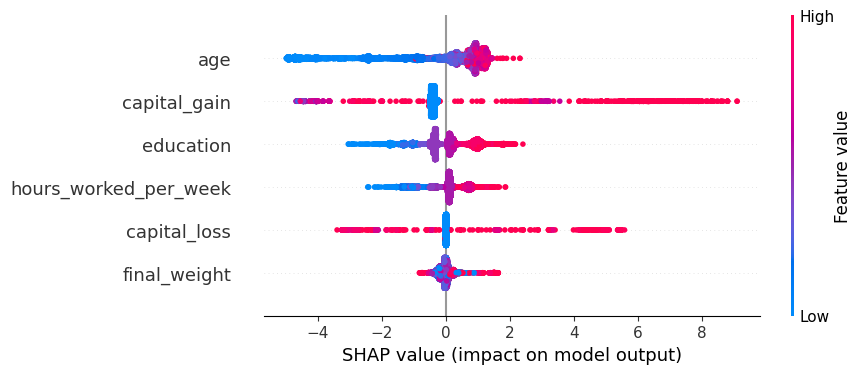

In [8]:
shap.plots.beeswarm(interventional_explanations)

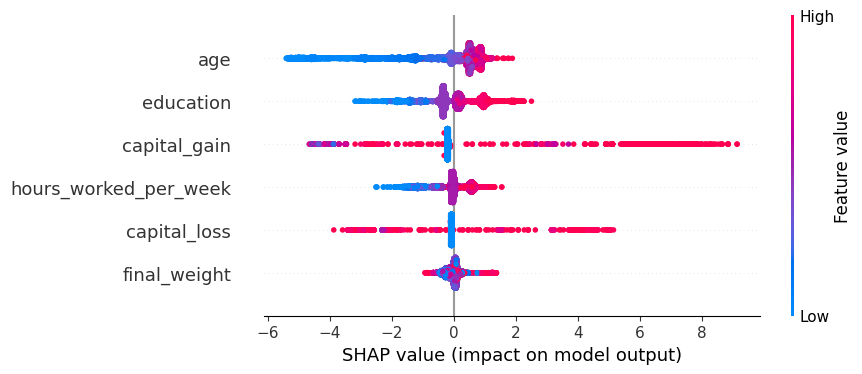

In [9]:
shap.plots.beeswarm(distributional_explanations)

**Observation.** Purely distributional and causal perturbation may impact the scores of perturbation-based algorithms.

Below, a quick analysis.

---

### Perturbation differences in Shap

In [10]:
import seaborn


explanation_differences = interventional_explanations.values - distributional_explanations.values
scaling_value = max((abs(interventional_explanations.values).max(), abs(distributional_explanations.values).max()))
maximum_differences_per_instance = explanation_differences.max(axis=1)
maximum_differences_per_feature = explanation_differences.max(axis=0)

<Axes: ylabel='Density'>

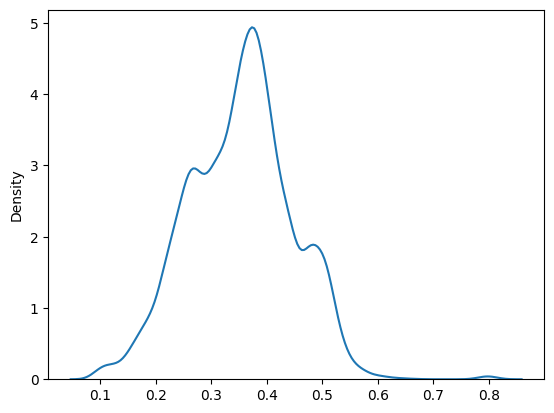

In [11]:
seaborn.kdeplot(maximum_differences_per_instance)

**Observation.** Most instances have a moderate-to-high explanation difference.

['age', 'capital_gain', 'capital_loss', 'education', 'final_weight', 'hours_worked_per_week']


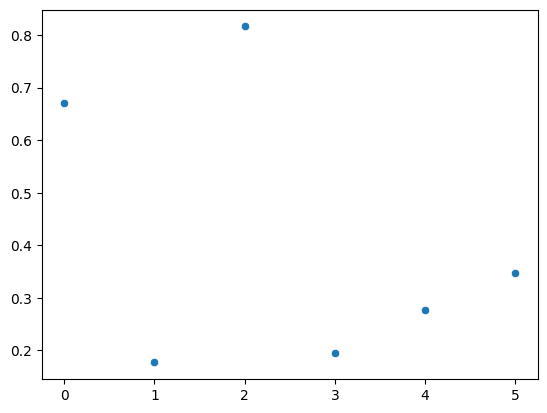

In [12]:
seaborn.scatterplot(maximum_differences_per_feature)
print(train_data.columns.tolist())

**Observation.** Age and capital loss are highly impacted by the use of causal/distributional perturbations.

## Explanation analysis

Are some features generally more impactful?

In [13]:
interventional_explanations_df = pandas.DataFrame(interventional_explanations.values, columns=train_data.columns.tolist())
interventional_explanations_df.describe().drop("count", axis="rows")

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week
mean,-0.087323,-0.177793,0.076873,0.006307,-0.004710,0.037056
std,1.644463,1.604386,0.807062,0.769378,0.238824,0.617987
min,-4.979287,-4.670721,-3.392260,-3.043842,-0.824030,-2.429471
25%,-0.497796,-0.468503,0.007755,-0.354947,-0.144400,0.055657
50%,0.631947,-0.390890,0.015973,0.090518,-0.005854,0.118226
75%,0.944306,-0.369501,0.018836,0.484405,0.065655,0.523835
max,2.315006,9.091379,5.580104,2.407696,1.639097,1.868571


#### For what instances are some features more/less impactful?

<Axes: xlabel='capital_gain', ylabel='Density'>

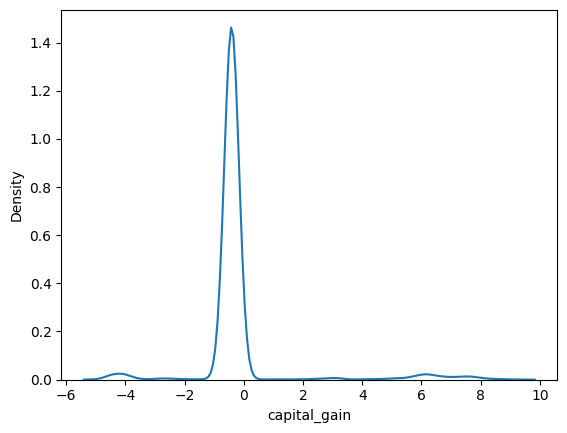

In [15]:
feature_of_interest = "capital_gain"
seaborn.kdeplot(interventional_explanations_df, x=feature_of_interest)

In [16]:
number_quantiles = 40
quantiles = interventional_explanations_df["age"].quantile([q / number_quantiles for q in (range(number_quantiles))])
quantiles.diff()  # pick differences in quantiles

0.000         NaN
0.025    0.293576
0.050    0.339766
0.075    0.384038
0.100    1.386365
0.125    0.218583
0.150    0.667704
0.175    0.406315
0.200    0.269443
0.225    0.184112
0.250    0.331591
0.275    0.304393
0.300    0.193052
0.325    0.149525
0.350    0.052794
0.375    0.092940
0.400    0.029818
0.425    0.061148
0.450    0.078076
0.475    0.078153
0.500    0.089845
0.525    0.066317
0.550    0.032987
0.575    0.029956
0.600    0.036629
0.625    0.044337
0.650    0.033051
0.675    0.016436
0.700    0.015983
0.725    0.014523
0.750    0.022142
0.775    0.041199
0.800    0.061900
0.825    0.043885
0.850    0.046337
0.875    0.027063
0.900    0.026823
0.925    0.033340
0.950    0.027362
0.975    0.023360
Name: age, dtype: float64

In [17]:
import numpy

quantile_of_interest = quantiles[0.1]
interested_explanations = interventional_explanations_df[feature_of_interest].values

highly_impacted_instances = numpy.argwhere(interested_explanations <= quantile_of_interest).squeeze()
moderately_impacted_instances = numpy.array([i for i in range(interventional_explanations.shape[0]) if i not in highly_impacted_instances])

### What are the differences in instances for which the selected features is highly important?

In [18]:
full_dataset.iloc[highly_impacted_instances].describe().drop("count", axis="rows") - full_dataset.iloc[moderately_impacted_instances].describe().drop("count", axis="rows")

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week
mean,0.503467,136.919939,19.079295,0.161094,-3645.357410,-0.432207
std,-0.825136,723.292388,23.959410,-0.211505,-7199.372988,-0.497129
min,0.000000,0.000000,0.000000,2.000000,5533.000000,1.000000
25%,1.000000,0.000000,0.000000,0.000000,1830.500000,-2.000000
50%,0.500000,0.000000,0.000000,0.000000,-2069.500000,0.000000
75%,0.000000,0.000000,0.000000,-1.000000,-6350.000000,0.000000
max,-11.000000,0.000000,-1456.000000,0.000000,-798750.000000,0.000000


<Axes: xlabel='capital_gain', ylabel='Density'>

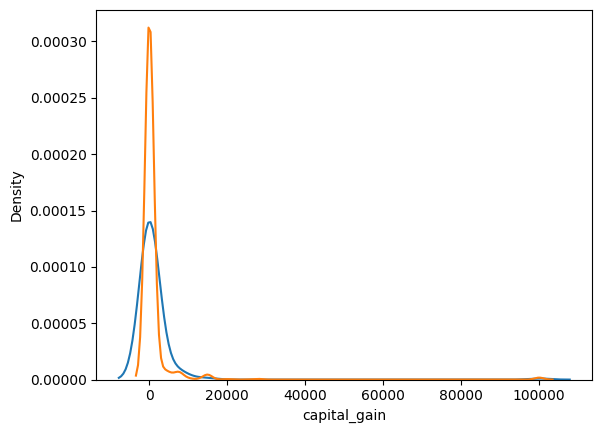

In [19]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="capital_gain")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="capital_gain")

<Axes: xlabel='hours_worked_per_week', ylabel='Density'>

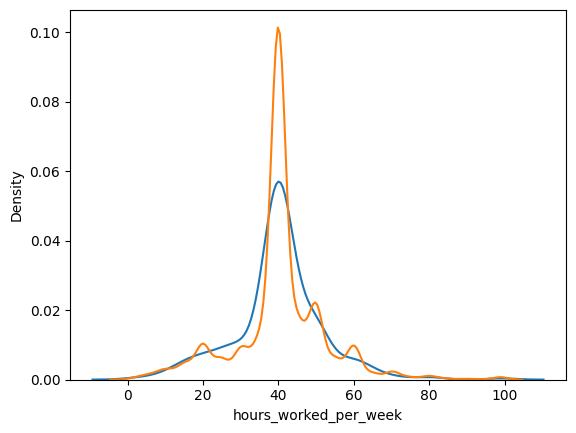

In [21]:
seaborn.kdeplot(full_dataset.iloc[highly_impacted_instances], x="hours_worked_per_week")
seaborn.kdeplot(full_dataset.iloc[moderately_impacted_instances], x="hours_worked_per_week")

---

## Validation

- Sensitivity to perturbation: does perturbation in the important features actually impact the model?
- Iterative removal: does removing important features worsen the model?
- Iterative addition: does adding important features improves the model?

We are starting from

In [28]:
pandas.DataFrame(validation)

,0,1,accuracy,macro avg,weighted avg
precision,0.856731,0.795771,0.84776,0.826251,0.842144
recall,0.960491,0.489391,0.84776,0.724941,0.847760
f1-score,0.905649,0.606061,0.84776,0.755855,0.833960
support,9289.000000,2922.000000,0.84776,12211.000000,12211.000000


### What features to work on? The most important ones!

In [29]:
mean_absolute_importances = interventional_explanations_df.abs().mean()
features_by_importance = interventional_explanations_df.columns[mean_absolute_importances.argsort()].tolist()
features_by_importance

['final_weight',
 'capital_loss',
 'hours_worked_per_week',
 'education',
 'capital_gain',
 'age']

We start by constructing a set of corrupted datasets where noise at different magnitudes is inserted into the original dataset...

In [30]:
random_noise = numpy.random.rand(test_data.shape[0],)
noise_magnitudes = [eps / 10 for eps in range(1, 10)]

corruptions_by_feature_and_noise = dict()
for feature in features_by_importance:
    for noise_magnitude in noise_magnitudes:
        corruptions_by_feature_and_noise[(feature, noise_magnitude)] = test_data.copy()
        corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] = corruptions_by_feature_and_noise[(feature, noise_magnitude)][feature] + random_noise * noise_magnitude

... then validating the model on it.

In [31]:
validations_by_feature_and_noise = dict()
for (feature, noise), corruption in corruptions_by_feature_and_noise.items():
    validations_by_feature_and_noise[(feature, noise)] = classification_report(test_labels, model.predict(corruption), output_dict=True)

In [32]:
metric = "f1-score"
corruption_validation = pandas.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise[(feature, noise_magnitude)]["weighted avg"][metric], "shap")
    for feature, noise_magnitude in validations_by_feature_and_noise
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation["difference"] = corruption_validation["performance"] - validation["weighted avg"][metric]
corruption_validation

,feature,noise_magnitude,performance,algorithm,difference
0,final_weight,0.1,0.834447,shap,0.000487
1,final_weight,0.2,0.833514,shap,-0.000445
2,final_weight,0.3,0.832454,shap,-0.001506
3,final_weight,0.4,0.833393,shap,-0.000567
4,final_weight,0.5,0.833012,shap,-0.000948
5,final_weight,0.6,0.831915,shap,-0.002045
6,final_weight,0.7,0.832436,shap,-0.001523
7,final_weight,0.8,0.832418,shap,-0.001542
8,final_weight,0.9,0.832756,shap,-0.001204
9,capital_loss,0.1,0.822576,shap,-0.011384


In [34]:
corruption_validation.groupby("feature").describe()[["performance", "difference"]]

performance                                          \
                            count      mean       std       min       25%   
feature                                                                     
age                           9.0  0.832547  0.001238  0.830303  0.831796   
capital_gain                  9.0  0.757985  0.006871  0.747307  0.753502   
capital_loss                  9.0  0.808156  0.010003  0.793468  0.800409   
education                     9.0  0.834023  0.000706  0.832928  0.833831   
final_weight                  9.0  0.832927  0.000763  0.831915  0.832436   
hours_worked_per_week         9.0  0.834239  0.001545  0.831595  0.833353   

                                                    difference            \
                            50%       75%       max      count      mean   
feature                                                                    
age                    0.832980  0.833376  0.833769        9.0 -0.001413   
capital_gain           0.760691  0.762171  0.768330        9.0 -0.075975   
capital_loss           0.811495  0.814727  0.822576        9.0 -0.025803   
education              0.833960  0.834017  0.835463        9.0  0.000063   
final_weight           0.832756  0.833393  0.834447        9.0 -0.001032   
hours_worked_per_week  0.833887  0.835404  0.836238        9.0  0.000279   

                                                                         \
                            std       min       25%       50%       75%   
feature                                                                   
age                    0.001238 -0.003657 -0.002163 -0.000979 -0.000584   
capital_gain           0.006871 -0.086652 -0.080458 -0.073268 -0.071789   
capital_loss           0.010003 -0.040492 -0.033550 -0.022465 -0.019233   
education              0.000706 -0.001031 -0.000129  0.000000  0.000057   
final_weight           0.000763 -0.002045 -0.001523 -0.001204 -0.000567   
hours_worked_per_week  0.001545 -0.002364 -0.000607 -0.000073  0.001444   

                                 
                            max  
feature                          
age                   -0.000190  
capital_gain          -0.065630  
capital_loss          -0.011384  
education              0.001503  
final_weight           0.000487  
hours_worked_per_week  0.002278

In [35]:
corruption_validation.groupby("noise_magnitude").describe()[["performance", "difference"]]

performance                                                    \
                      count      mean       std       min       25%       50%   
noise_magnitude                                                                 
0.1                     6.0  0.821096  0.026247  0.768330  0.825276  0.833631   
0.2                     6.0  0.818898  0.028505  0.762171  0.821429  0.833081   
0.3                     6.0  0.818050  0.028265  0.762300  0.818944  0.832025   
0.4                     6.0  0.817911  0.029213  0.760863  0.817578  0.833380   
0.5                     6.0  0.817262  0.030379  0.757924  0.816874  0.833182   
0.6                     6.0  0.816343  0.029564  0.760691  0.811504  0.832333   
0.7                     6.0  0.814641  0.032779  0.753502  0.808256  0.832116   
0.8                     6.0  0.813061  0.035599  0.747307  0.804851  0.831703   
0.9                     6.0  0.812555  0.035112  0.748775  0.802676  0.831530   

                                    difference                                \
                      75%       max      count      mean       std       min   
noise_magnitude                                                                
0.1              0.833941  0.834447        6.0 -0.012864  0.026247 -0.065630   
0.2              0.833431  0.833960        6.0 -0.015062  0.028505 -0.071789   
0.3              0.833060  0.833960        6.0 -0.015910  0.028265 -0.071660   
0.4              0.833621  0.833831        6.0 -0.016049  0.029213 -0.073097   
0.5              0.833665  0.834017        6.0 -0.016698  0.030379 -0.076035   
0.6              0.832884  0.835071        6.0 -0.017617  0.029564 -0.073268   
0.7              0.833208  0.836238        6.0 -0.019319  0.032779 -0.080458   
0.8              0.834701  0.836052        6.0 -0.020898  0.035599 -0.086652   
0.9              0.834156  0.835404        6.0 -0.021405  0.035112 -0.085185   

                                                         
                      25%       50%       75%       max  
noise_magnitude                                          
0.1             -0.008684 -0.000328 -0.000018  0.000487  
0.2             -0.012530 -0.000878 -0.000528  0.000000  
0.3             -0.015016 -0.001935 -0.000900  0.000000  
0.4             -0.016382 -0.000580 -0.000339 -0.000129  
0.5             -0.017086 -0.000777 -0.000294  0.000057  
0.6             -0.022455 -0.001626 -0.001076  0.001112  
0.7             -0.025704 -0.001843 -0.000752  0.002278  
0.8             -0.029108 -0.002256  0.000742  0.002092  
0.9             -0.031283 -0.002430  0.000196  0.001444

For iterative removal and addition... simply filter the dataset and train from scratch! Note that results may not align with Shap due to the estimated null values.

---

# Surrogate-based explanation

Family of models which generate a "local" neighborhood of the given instance, then learn a surrogate interpretable model on such neighborhood.


<img style="width: 25%;" src="https://cdn.jsdelivr.net/gh/msetzu/marpee@latest/assets/imgs/papers/pivot_tree/SVG/pivottree_space.svg">


## LIME

Lime learns either a random or sampled neighborhood.
Sampling leverages a distribution induced from the given data.

Available on [interpretml](https://interpret.ml/docs/lime.html)

In [ ]:
!pip install interpret lime

In [41]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret import show
from tqdm import tqdm


set_visualize_provider(InlineProvider())

In [42]:
from interpret.blackbox import LimeTabular


explanation_algorithm = LimeTabular(model, train_data)
explanations["lime"] = numpy.array([numpy.array(e["scores"])
                                    for e in tqdm(explanation_algorithm.explain_local(train_data[:100], train_labels[:100])._internal_obj["specific"])])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 371177.35it/s]


In [43]:
metric = "f1-score"
corruption_validation_lime = pandas.DataFrame([
    (feature, noise_magnitude, validations_by_feature_and_noise[(feature, noise_magnitude)]["weighted avg"][metric], "lime")
    for feature, noise_magnitude in validations_by_feature_and_noise
    ],
    columns=["feature", "noise_magnitude", "performance", "algorithm"]
)
corruption_validation_lime["difference"] = corruption_validation_lime["performance"] - validation["weighted avg"][metric]

corruption_validation = pandas.concat((corruption_validation, corruption_validation_lime))
corruption_validation_lime

,feature,noise_magnitude,performance,algorithm,difference
0,final_weight,0.1,0.834447,lime,0.000487
1,final_weight,0.2,0.833514,lime,-0.000445
2,final_weight,0.3,0.832454,lime,-0.001506
3,final_weight,0.4,0.833393,lime,-0.000567
4,final_weight,0.5,0.833012,lime,-0.000948
5,final_weight,0.6,0.831915,lime,-0.002045
6,final_weight,0.7,0.832436,lime,-0.001523
7,final_weight,0.8,0.832418,lime,-0.001542
8,final_weight,0.9,0.832756,lime,-0.001204
9,capital_loss,0.1,0.822576,lime,-0.011384


In [44]:
corruption_validation

,feature,noise_magnitude,performance,algorithm,difference
0,final_weight,0.1,0.834447,shap,0.000487
1,final_weight,0.2,0.833514,shap,-0.000445
2,final_weight,0.3,0.832454,shap,-0.001506
3,final_weight,0.4,0.833393,shap,-0.000567
4,final_weight,0.5,0.833012,shap,-0.000948
...,...,...,...,...,...
49,age,0.5,0.833769,lime,-0.000190
50,age,0.6,0.832751,lime,-0.001208
51,age,0.7,0.831796,lime,-0.002163
52,age,0.8,0.830989,lime,-0.002971


## Lore

Lore employs a genetic neighborhood generation algorithm, which balances:

- Distance from the given instance
- Label balance of the neighborhood

The surrogate model is a decision tree, thus allowing extraction of decision rules.

In [ ]:
!pip install XAI-Library

In [46]:
from xailib.explainers.lore_explainer import LoreTabularExplainer


explanation_algorithm = LoreTabularExplainer(model)
configuration = {
    "neigh_type": "rndgen",
    "size": 1000,
    "ocr": 0.1,
    "ngen": 100
}

lore_train_data = pandas.concat((train_data, train_labels), axis="columns")
explanation_algorithm.fit(lore_train_data, "over_threshold", config=configuration)
explanation = explanation_algorithm.explain(train_data.iloc[0].values)

In [47]:
# extract decision rule for the given instance
explanation.getRules()

{'premise': [{'att': 'capital_gain',
   'op': '<=',
   'thr': 0.24129363149404526,
   'is_continuous': True},
  {'att': 'capital_loss',
   'op': '<=',
   'thr': 4.210907936096191,
   'is_continuous': True},
  {'att': 'capital_loss',
   'op': '>',
   'thr': -0.9984815716743469,
   'is_continuous': True},
  {'att': 'education',
   'op': '<=',
   'thr': 0.9420311152935028,
   'is_continuous': True},
  {'att': 'final_weight',
   'op': '<=',
   'thr': 2.0900540351867676,
   'is_continuous': True}],
 'cons': 0,
 'class_name': 'over_threshold'}

The tree structure allows for free counterfactual rules! Simply traverse the tree in alternative paths.

In [48]:
# extract counterfactual explanation
explanation.getCounterfactualRules()

[{'premise': [{'att': 'capital_gain',
    'op': '<=',
    'thr': 0.24129363149404526,
    'is_continuous': True},
   {'att': 'capital_loss',
    'op': '>',
    'thr': 5.261775493621826,
    'is_continuous': True},
   {'att': 'final_weight',
    'op': '>',
    'thr': -1.5334717631340027,
    'is_continuous': True}],
  'cons': 1,
  'class_name': 'over_threshold'}]

In [49]:
explanation.plotRules()

Lore also provides *local* fidelity, i.e., accuracy of the model w.r.t. the model, computed on the generated neighborhood.

In [50]:
explanation.expDict["fidelity"]

0.9886549644244271

In [51]:
explanation.expDict.keys()

dict_keys(['bb_pred', 'dt_pred', 'rule', 'crules', 'deltas', 'fidelity', 'dt'])

---

# Counterfactual explanations

Counterfactuals look for changes in the instance to change the prediction of the model.

In [ ]:
pip install dice-ml

In [ ]:
import dice_ml


# need to convert data to the Dice format
dice_train_dataset = train_data.copy()
dice_train_dataset["over_threshold"] = train_labels
dice_dataset = dice_ml.Data(
    dataframe=dice_train_dataset,
    outcome_name="over_threshold",
    continuous_features=dice_train_dataset.columns.tolist()[:-1]
)

dice_model = dice_ml.Model(
    model=model,
    backend="sklearn",  # dice supports several frameworks, e.g., pytorch, tensorflow
)

In [378]:
# the Dice object interfaces the counterfactual search
explanation_algorithm = dice_ml.Dice(
    dice_dataset,
    dice_model,
    method="random"  # random search for counterfactuals
    # method="gradient"  # gradient ASCent
    # method="genetic"  # genetic algorithm for search
)

explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.head(1).drop("over_threshold", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
)

100%|███████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.63it/s]


In [379]:
explanation.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,over_threshold
0,0.317746,-0.144804,-0.217127,-0.030373,-1.471419,-0.437595,0



Diverse Counterfactual set (new outcome: 1)


,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,over_threshold
0,-,3.78861779,-,-,-,3.291780287,1.0
1,-,-,4.5342028,-,-,-,1.0
2,-,-,-,1.40550875,-,0.332841409,1.0
3,-,-,6.895535,-,-,-,1.0
4,-,11.58106475,-,-,-,-,1.0
5,-,11.30140195,-,-,-,-,1.0
6,-,4.67312183,-,-,-,-,1.0
7,-,6.7641918,-,-1.4709097,-,-,1.0
8,-,12.96823536,-,1.22837261,-,-,1.0
9,-,-,9.097357,-,-1.62206071,-,1.0


Counterfactual search also admits a feasible region, as to yield *plausible* counterfactuals.

In [391]:
explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.head(1).drop("over_threshold", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
    permitted_range= {  # feature constraints
        "capital_loss": [-0.217127, 0.0]
    },
    features_to_vary = ["hours_worked_per_week", "capital_loss", "capital_gain"],  # more feature constraints
    stopping_threshold = 0.2
)


100%|███████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.05s/it]


In [392]:
explanation.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,over_threshold
0,0.317746,-0.144804,-0.217127,-0.030373,-1.471419,-0.437595,0



Diverse Counterfactual set (new outcome: 1)


,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,over_threshold
0,-,7.80629173,-,-,-,-,1.0
1,-,10.92677876,-,-,-,-,1.0
2,-,3.67248651,-,-,-,-,1.0
3,-,1.34964485,-0.033277200000028755,-,-,-,1.0
4,-,10.4681075,-,-,-,-,1.0
5,-,8.82892362,-,-,-,3.343377009,1.0
6,-,12.57637218,-,-,-,-,1.0
7,-,6.6213252,-,-,-,-,1.0
8,-,9.66978243,-,-,-,-,1.0
9,-,4.54561848,-,-,-,-,1.0


In [395]:
explanation = explanation_algorithm.generate_counterfactuals(
    dice_train_dataset.head(1).drop("over_threshold", axis="columns"),
    total_CFs=10,  # number of counterfactuals to generate
    features_to_vary = ["hours_worked_per_week"],  # more feature constraints
    stopping_threshold = 0.2
)

100%|███████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.28it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


UserConfigValidationException: No counterfactuals found for any of the query points! Kindly check your configuration.

In [384]:
help(explanation_algorithm.generate_counterfactuals)

Help on method generate_counterfactuals in module dice_ml.explainer_interfaces.explainer_base:

generate_counterfactuals(query_instances, total_CFs, desired_class='opposite', desired_range=None, permitted_range=None, features_to_vary='all', stopping_threshold=0.5, posthoc_sparsity_param=0.1, proximity_weight=0.2, sparsity_weight=0.2, diversity_weight=5.0, categorical_penalty=0.1, posthoc_sparsity_algorithm='linear', verbose=False, **kwargs) method of dice_ml.explainer_interfaces.dice_random.DiceRandom instance
    General method for generating counterfactuals.

    :param query_instances: Input point(s) for which counterfactuals are to be generated.
                            This can be a dataframe with one or more rows.
    :param total_CFs: Total number of counterfactuals required.
    :param desired_class: Desired counterfactual class - can take 0 or 1. Default value
                          is "opposite" to the outcome class of query_instance for binary classification.
    :para